In [1]:
from scipy import integrate
import pandas as pd
import numpy as np
import noisegen
from scipy.constants import physical_constants
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.integrate
import matplotlib

matplotlib.rcParams.update({'font.size': 22})

In [2]:
# Define a function to calculate the qubit gap as a function of the flux noise.
def delta_gap_func(delta_flux, D=1):
    return delta_flux*D

# Define a function which produces a white noise power spectrum with a UV cutoff.
def psd_func(f, A, f_uv):
    mask = np.abs(f) < f_uv
    return A*mask

According to the thesis of Audrey Cottet (http://www-drecam.cea.fr/drecam/spec/Pres/Quantro, equation 3.10, page 158) over a sufficiently long timescale the coherence of a qubit decays exponentially:

$$
f_\phi(t) = \exp \big( - \Gamma_\phi t \big)
$$

where
$$
\Gamma_\phi = 2 (\pi D)^2 S(0)
$$


where $D = \frac{d f_{01}}{ d \lambda}$ is the derivative of the qubit gap in natural frequency units with respect to the noise parameter $\lambda$, and $S(0)$ is the noise power spectral density in natural frequency units.

In [15]:
A = 1.0
f_uv = 1.0
seed = 0
cutoff_time = None
n_traces = 2**11
n_frequencies = 10000
f_interval = 0.1

# Initialise the noise generator.
generator = noisegen.NoiseGenerator(n_frequencies, f_interval)

# Take samples of the power spectral density.
psd = psd_func(generator.fft_frequencies, A, f_uv)
generator.specify_psd(psd=psd)

# Generate noise samples.
generator.generate_trace_truncated(seed=seed, n_traces=n_traces, cutoff_time=cutoff_time)

/home/paul/PycharmProjects/noisegen/noisegen/generator.py:36: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if psd == 'white':
/home/paul/PycharmProjects/noisegen/noisegen/generator.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif psd == 'pink':
100%|██████████| 2048/2048 [00:07<00:00, 289.75it/s]


In [16]:
# D = derivative of qubit gap in natural frequency units with respect to the noise.
D = 5e0
delta_gap = delta_gap_func(generator.samples, D=D)
phase = 2*np.pi*pd.DataFrame(integrate.cumtrapz(delta_gap,x=delta_gap.index,axis=0),index=delta_gap.index[1:])
coherence = np.exp(1j*phase).mean(axis=1).abs()

In [17]:
def sinc(x):
    return np.sinc(x/np.pi)

def integrand_func(f, t, A, f_uv):
    return sinc(np.pi*f*t)**2 * psd_func(f, A, f_uv)

def ms_phase_func(t, D, A, f_uv, eps=1e-9, limit=50):
    integrator_args = (t, A, f_uv)
    f_0 = -f_uv
    f_1 = f_uv
    ms_phase = (2*np.pi*D*t)**2 * scipy.integrate.quad(integrand_func, f_0, f_1, args=integrator_args, epsabs=eps, epsrel=eps, limit=limit)[0]
    return ms_phase

In [18]:
mean_square_phase = (phase**2).mean(axis=1)

In [19]:
times = np.linspace(mean_square_phase.index[0], mean_square_phase.index[-1], 201)
mean_square_phase_analytic = [ms_phase_func(t, D, A, f_uv) for t in times]
mean_square_phase_analytic = pd.Series(mean_square_phase_analytic, index=times)

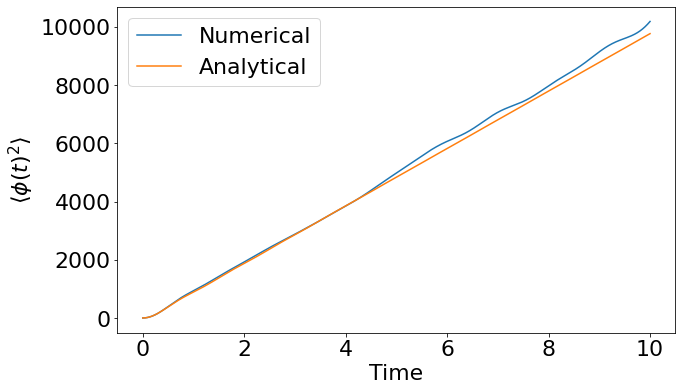

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

mean_square_phase.plot(ax=axes, label='Numerical')
mean_square_phase_analytic.plot(ax=axes, label='Analytical')

axes.set_ylabel(r'$\langle \phi(t)^2 \rangle$')
axes.set_xlabel('Time')

legend = axes.legend()